# Second model 

This model will try to predict wether pe is present or not on a full image (RGB level)

## Imports

In [1]:
import numpy as np
from modules.balance import *
from modules.model import *
from torchsummary import summary

In [10]:
import torch
torch.cuda.empty_cache()

print(f'PyTorch version: {torch.__version__}')
print("GPU found :)" if torch.cuda.is_available() else "No GPU :(")

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

PyTorch version: 1.7.1
GPU found :)


# Load dataset

In [11]:
full_image_dataset = torch.load('datasets/full_image_dataset.pt')

## Simple CNN from scratch

In [12]:
class ModelV2(nn.Module):
    
    def __init__(self, input_channels):
        """Simple Convnet with 2 convolution layer + pooling, with 2 fully connected at the end"""
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(32, 32, 3)
        self.fc1 = nn.Linear(32*62*62 , 120)
        self.fc2 = nn.Linear(120, 1)
        self.sigmoid = nn.Sigmoid()
        
        
    def forward(self, x):
        
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32*62*62) # Flatten
        x = F.relu(self.fc1(x))
        
        # Binary classification
        out = self.sigmoid(self.fc2(x))
        
        return out

In [13]:
model = ModelV2(3).to(device)
summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 254, 254]             896
         MaxPool2d-2         [-1, 32, 127, 127]               0
            Conv2d-3         [-1, 32, 125, 125]           9,248
         MaxPool2d-4           [-1, 32, 62, 62]               0
            Linear-5                  [-1, 120]      14,761,080
            Linear-6                    [-1, 1]             121
           Sigmoid-7                    [-1, 1]               0
Total params: 14,771,345
Trainable params: 14,771,345
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.75
Forward/backward pass size (MB): 24.44
Params size (MB): 56.35
Estimated Total Size (MB): 81.54
----------------------------------------------------------------


## Split data into train and test

In [17]:
batch_size = 2
ratio=0.2

train_loader, test_loader = train_test_split(full_image_dataset, ratio, batch_size)

## Model Training

In [7]:
num_epoch = 10
criterion = nn.BCELoss()
optimizer=optim.Adam(model.parameters(), lr=0.001)
save_filename = './models/model_v2.h5'

model, losses = train(model, num_epoch, criterion, train_loader, optimizer, device, save_filename)

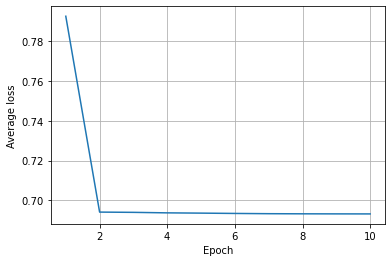

In [8]:
plot_loss(losses, num_epoch, len(train_loader), './figures/Loss model v2 full image.png')

## Test the model

In [15]:
# Load model for evaluation
trained_model = ModelV2(input_channels=3)
trained_model.load_state_dict(torch.load('./models/model_v2.h5'))
trained_model.to(device)

ModelV2(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=123008, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [18]:
accuracy, total = evaluate(trained_model, test_loader, device)

In [19]:
print(f'Accuracy of the network on the {total} test images: {accuracy:.2f}')

Accuracy of the network on the 1254 test images: 50.88
